In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import sys
PROJECT_ROOT = os.path.abspath(os.curdir) ## Please make sure it outputs the correct root, No universal solution for Colab - Jupyter - Local environment
PROJECT_ROOT += "/drive/MyDrive/GCN/" 
print('The Project is running from : ', PROJECT_ROOT)
sys.path.append(PROJECT_ROOT)

The Project is running from :  /content/drive/MyDrive/GCN/


In [3]:
from __future__ import print_function, absolute_import, division

import os
import time
import datetime
import argparse
import numpy as np
import os.path as path
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
import pickle

from progress.bar import Bar
from common.log import Logger, savefig
from common.utils import AverageMeter, lr_decay, save_ckpt
from common.graph_utils import adj_mx_from_skeleton
from common.data_utils import fetch, read_3d_data, create_2d_data
from common.generators import PoseGenerator,PoseGenerator_Multi,PoseGenerator_Multi_Concat
from common.generators import PoseGenerator,PoseGenerator_Multi
from common.loss import mpjpe, p_mpjpe
from models.Sem_gcn_multiView import SemGCN_Concat_Non_Shared,SemGCN_Sum_Non_Shared,SemGCN_Concat_Shared,SemGCN_Sum_Shared,SemGCN_Camera_Concat_World
from models.sem_gcn import SemGCN
from sklearn.metrics import mean_squared_error
from models.MLP import mlp_model

In [4]:
adj = torch.tensor([[0.2500, 0.2500, 0.0000, 0.0000, 0.2500, 0.0000, 0.0000, 0.2500, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.0000, 0.0000, 0.0000, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.3333, 0.3333, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.5000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.3333,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2000, 0.2000,
         0.2000, 0.2000, 0.0000, 0.0000, 0.2000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000,
         0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333,
         0.0000, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.5000, 0.5000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3333,
         0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.3333, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.3333, 0.3333, 0.3333],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000, 0.5000]])

HID_DIM = 128
NUM_LAYERS = 4
NUM_LAYERS_DEEP = 8
P_DROPOUT = None
BATCH_SIZE = 64
NUM_WORKERS = 2
LR = 0.001

In [5]:
def pickle_read(filename):
        with open(filename, "rb") as f:
                data = pickle.load(f)
        return data




In [6]:
## Expects poses_list to be in dimensions (n,3,nb_of_joints) with n being the number of poses to overlay
def display_poses(poses_list,f,nb_rows,nb_cols,pos, save_loc=None, custom_name=None, time=0, custom_title=None, legend_=None, color_list=["blue","red"]):
    fig = f
    bone_connections = [[0,1],[0,4],[1,2],[2,3],[4,5],[5,6],[0,7],[7,8],[8,9],[8,10],[8,13],[10,11],[11,12],[13,14],[14,15]]

    ax = fig.add_subplot(nb_rows,nb_cols,pos,projection='3d')
    plots = []
    for ind, poses in enumerate(poses_list):
        X = poses[0,:]
        Y = poses[1,:]
        Z = poses[2,:]
        for _, bone in enumerate(bone_connections):
            bone = list(bone)
            p, = ax.plot(X[bone], Y[bone], Z[bone], c=color_list[ind], marker="o", markersize=6, linewidth=3)

            if len(plots) <= ind:
                plots.append(p)

        ax.set_xlim(-0.3,0.3)
        ax.set_ylim(-0.3,0.3)
        ax.set_zlim(-0.3,0.3)

        ax.view_init(elev=-90., azim=-90)

    # Hide grid lines
    ax.grid(False)

    # Hide axes ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    
    # Get rid of the panes                          
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0)) 
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0)) 
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0)) 

    # Get rid of the spines                         
    ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0)) 
    ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0)) 
    ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

    if custom_title is not None:
        ax.set_title(custom_title)

    if legend_ is not None:
        ax.legend(plots, legend_)

    if save_loc is not None:
        plt.savefig(save_loc + '/' + custom_name + str(time) + '.png', dpi=100)

    return f

In [7]:
poses_to_print = [('frame_016064','SQUAT','1',3036),
                  ('frame_032315','Lunges','1', 15540),
                  ('frame_054338','Plank','1', 32324),
                  ('frame_073385','Pick-up','1', 56044)]

def batch_locator(index,batch_size,test_set_size):
  nb_of_batches = int(test_set_size / batch_size) + 1 
  concerned_batch = int(index / batch_size)
  relative_index = index % (concerned_batch*batch_size)
  return concerned_batch,relative_index

poses_batch = []
poses_index_in_batch = {}

for i in range(len(poses_to_print)):
  i,j = batch_locator(poses_to_print[i][3],batch_size=BATCH_SIZE,test_set_size=73456)

  poses_batch.append(i)
  poses_index_in_batch[i] = j



poses_batch_mv = []
poses_index_in_batch_mv = {}

for i in range(len(poses_to_print)):
  i,j = batch_locator(int(poses_to_print[i][3]/4),batch_size=BATCH_SIZE,test_set_size=73456/4)

  poses_batch_mv.append(i)
  poses_index_in_batch_mv[i] = j





==> Loading dataset...
Preparing model 0
Preparing model 1
Preparing model 2
Preparing model 3


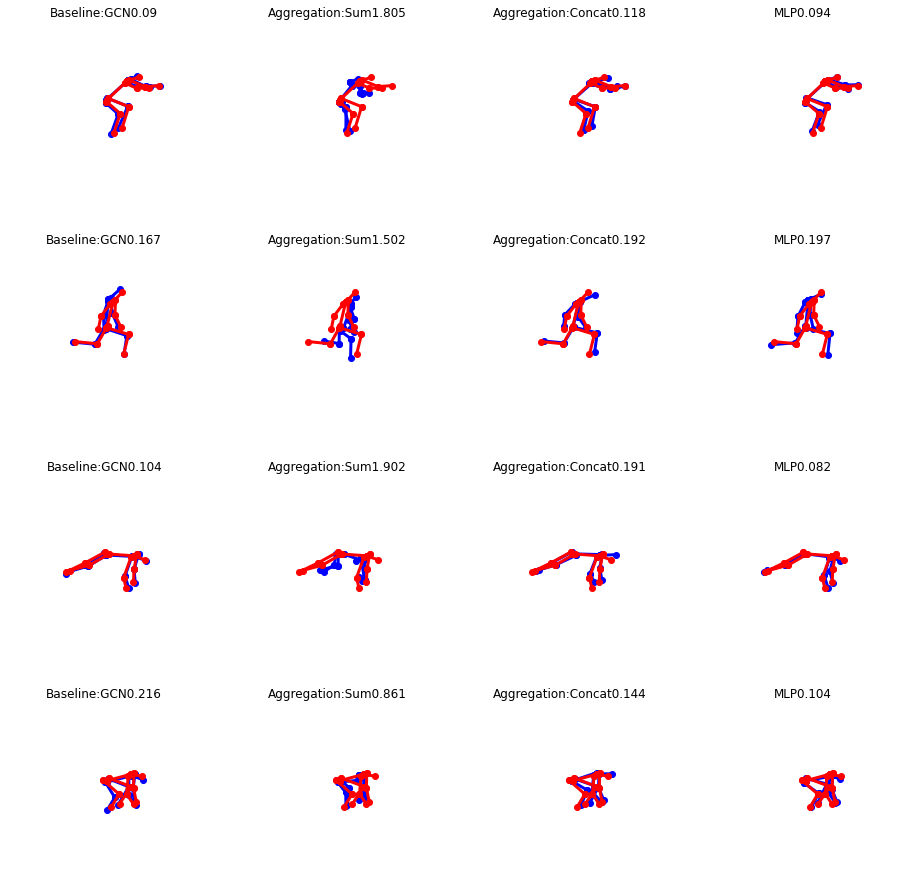

In [8]:
print('==> Loading dataset...')

_2d_training = pickle_read(PROJECT_ROOT+"data/2D_CAMERA_TRAINING_FOR_3D_CAMERA.pickle")
_3d_training_CAM = pickle_read(PROJECT_ROOT+"data/3D_CAMERA_TRAINING_VF.pickle")
_3d_training_WORLD = pickle_read(PROJECT_ROOT+"data/3D_WORLD_TRAINING.pickle")

_2d_test = pickle_read(PROJECT_ROOT+"data/2D_CAMERA_TEST_FOR_3D_CAMERA.pickle")
_3d_test_CAM = pickle_read(PROJECT_ROOT+"data/3D_CAMERA_TEST_VF.pickle")
_3d_test_WORLD = pickle_read(PROJECT_ROOT+"data/3D_WORLD_TEST.pickle")  




actions_train = ['SomeAction1' for i in range(0,len(_3d_training_WORLD))]
actions_test = ['SomeAction1' for i in range(0,len(_3d_test_WORLD))]


cudnn.benchmark = True
device = torch.device("cuda")


models_to_evaluate = [
                      ("Baseline:GCN",
                       SemGCN(adj, HID_DIM, num_layers=NUM_LAYERS, p_dropout=P_DROPOUT,nodes_group=None),
                       "Final_Paper_Config_World/2023-01-02T15:25:51.289933/ckpt_best.pth.tar"),
                      ("Aggregation:Sum",
                       SemGCN_Sum_Non_Shared(adj, HID_DIM, num_layers=NUM_LAYERS, p_dropout=P_DROPOUT,nodes_group=None),
                       "Final_Demi_Paper_Sum_Non_Shared/2023-01-02T17:53:04.688226/ckpt_best.pth.tar"),
                      ("Aggregation:Concat",
                       SemGCN_Concat_Non_Shared(adj, HID_DIM, num_layers=NUM_LAYERS, p_dropout=P_DROPOUT,nodes_group=None),
                       "Final_Demi_Paper_Concat_Non_Shared/2023-01-02T16_07_41.132813/ckpt_best.pth.tar"),   
                      ("MLP",
                       mlp_model(nb_hidden_layers = 1),
                       "Final_MLP_WORLD/2023-01-12T20:49:55.903304/ckpt_best.pth.tar")                              
                      ]




                    

f = plt.figure(figsize=(16,16))
nb_rows = len(poses_to_print)
nb_cols = len(models_to_evaluate)


valid_loader_mono = DataLoader(PoseGenerator(_3d_test_WORLD, _2d_test, actions_test), batch_size=BATCH_SIZE,
                                                    shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

valid_loader_multi = DataLoader(PoseGenerator_Multi(_3d_test_WORLD, _2d_test, actions_test), batch_size=BATCH_SIZE,
                                                    shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)  

for i in range(len(models_to_evaluate)):
  model_name = models_to_evaluate[i][0]  
  print("Preparing model", i)
  model_pos = models_to_evaluate[i][1].to(device)
  path = PROJECT_ROOT+models_to_evaluate[i][2]
  criterion = nn.MSELoss(reduction='mean').to(device)
  optimizer = torch.optim.Adam(model_pos.parameters(), lr=LR)
  ckpt = torch.load(path)
  start_epoch = ckpt['epoch']
  error_best = ckpt['error']
  glob_step = ckpt['step']
  lr_now = ckpt['lr']
  model_pos.load_state_dict(ckpt['state_dict'])
  optimizer.load_state_dict(ckpt['optimizer'])
  torch.set_grad_enabled(False)
  model_pos.eval()
  poses_count = 0

  if(model_name == "MLP"):
    valid_loader = valid_loader_mono
    for j,(t,inp,_) in enumerate(valid_loader):
      if j in poses_batch:
        inp = torch.flatten(inp,start_dim = 1)
        inp = inp.to(device)  
        outputs_3ds = model_pos(inp).cpu()
        inp = inp.cpu().detach().numpy()
        outputs_3ds = outputs_3ds.detach().numpy().reshape((64,16,3))
        pred =  outputs_3ds[poses_index_in_batch[j]].T.reshape((1,3,16))
        gd =  t[poses_index_in_batch[j]].T.reshape((1,3,16))
        loss_local = mean_squared_error(pred.reshape((3,16)),gd.reshape((3,16)))
        loss_local = str(round(loss_local*1000,3))
        f = display_poses(np.concatenate((pred,gd),axis=0),f=f,nb_rows=nb_rows,nb_cols=nb_cols,pos=poses_count*nb_cols+i+1,custom_title=model_name+loss_local)
        poses_count += 1
  
  
  elif(model_name == "Baseline:GCN"):
    valid_loader = valid_loader_mono
    for j,(t,inp,_) in enumerate(valid_loader):
      if j in poses_batch:
        inp = inp.to(device)  
        outputs_3ds = model_pos(inp).cpu()
        inp = inp.cpu().detach().numpy()
        outputs_3ds = outputs_3ds.detach().numpy()
        pred =  outputs_3ds[poses_index_in_batch[j]].T.reshape((1,3,16))
        gd =  t[poses_index_in_batch[j]].T.reshape((1,3,16))
        loss_local = mean_squared_error(pred.reshape((3,16)),gd.reshape((3,16)))
        loss_local = str(round(loss_local*1000,3))
        f = display_poses(np.concatenate((pred,gd),axis=0),f=f,nb_rows=nb_rows,nb_cols=nb_cols,pos=poses_count*nb_cols+i+1,custom_title=model_name+loss_local)
        poses_count += 1
  

  else:
    valid_loader = valid_loader_multi
    for j, (targets_3d, input_1,input_2,input_3,input_4, _) in enumerate(valid_loader):
      if j in poses_batch_mv:
        input_1,input_2,input_3,input_4 = input_1.to(device),input_2.to(device),input_3.to(device),input_4.to(device)
        
        outputs_3d = model_pos(input_1,input_2,input_3,input_4).cpu()
        outputs_3d = outputs_3d.cpu().detach().numpy()
        pred =  outputs_3d[poses_index_in_batch_mv[j]].T.reshape((1,3,16))
        gd =  targets_3d[poses_index_in_batch_mv[j]].T.reshape((1,3,16))
        loss_local = mean_squared_error(pred.reshape((3,16)),gd.reshape((3,16)))
        loss_local = str(round(loss_local*1000,3))
        f = display_poses(np.concatenate((pred,gd),axis=0),f=f,nb_rows=nb_rows,nb_cols=nb_cols,pos=poses_count*nb_cols+i+1,custom_title=model_name+loss_local)
        poses_count += 1
           
f




In [9]:
plt.savefig(PROJECT_ROOT+"Very_Final_Results_with_MLP.png")